In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
"""Numpy example that works"""

import sys
sys.path.append('/home/bostjand/work/GHutils/Stein-Variational-Gradient-Descent/python')  ## Tale paket je z neta, dobiš ga na githubu 
### https://github.com/dilinwang820/Stein-Variational-Gradient-Descent.git
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import mpld3

import numpy.matlib as nm

from svgd import SVGD
import scipy.stats as stats



class MultiModalNormal(object):
    def __init__(self, mu1, s1, mu2,s2):
        self.mu1 = mu1
        self.mu2 = mu2
        self.s1 = s1
        self.s2 = s2
        
        pdf, log_pdf, d_log_pdf = self.__sym_log_prob()
        self.pdf = lambda x : pdf(x, self.mu1, self.s1, self.mu2, self.s2)
        self.log_pdf = lambda x : log_pdf(x, self.mu1, self.s1, self.mu2, self.s2)
        self.d_log_pdf = lambda x : d_log_pdf(x, self.mu1, self.s1, self.mu2, self.s2)
        
        
        
    def __sym_log_prob(self):
        import sympy
        
        x, m1,s1, m2,s2 = sympy.symbols('x m1 s1 m2 s2')
        
        
        f1 = 1/sympy.sqrt(2*sympy.pi*sympy.Pow(s1, 2)) * sympy.exp(- (x-m1)**2/(2*s1**2 ))
        f2 = 1/sympy.sqrt(2*sympy.pi*sympy.Pow(s2, 2)) * sympy.exp(- (x-m2)**2/(2*s2**2 ))
        
        f = 1/3*f1  +2/3*f2
        log_f = sympy.ln(f)        
        d_log_f = sympy.diff(log_f, x)
        
        from sympy import lambdify
        
        N_f = lambdify((x, m1,s1, m2, s2), f)
        N_log_f = lambdify((x, m1,s1, m2, s2), log_f)        
        N_d_log_f = lambdify((x, m1,s1, m2, s2), d_log_f)   
        
        
        return N_f, N_log_f, N_d_log_f

mu1, mu2 = -2., 2.
s1 , s2  =  1., 1.

        
Model = MultiModalNormal(mu1, s1, mu2, s2)

x = np.linspace(-10,10, 200)
p = Model.pdf(x)

x0 = np.random.normal(-12,10., [100,1])
theta = SVGD().update(x0, Model.d_log_pdf, n_iter=1, stepsize=0.05)

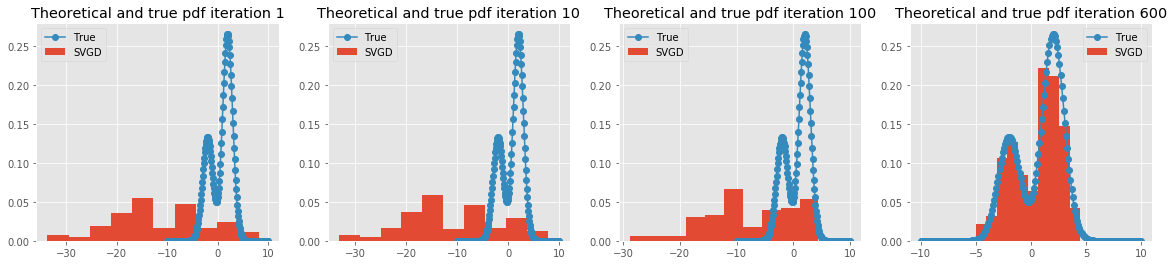

CPU times: user 683 ms, sys: 7.29 ms, total: 690 ms
Wall time: 689 ms


In [3]:
%%time

plt.figure(figsize = (20, 4))
i = 1
tot_iter = i
theta = SVGD().update(theta, Model.d_log_pdf, n_iter=i, stepsize=0.05)
plt.subplot(1,4,1)
plt.title('Theoretical and true pdf iteration ' +str(tot_iter))
plt.hist(theta, density = True, label = 'SVGD')
plt.plot(x, Model.pdf(x), '-o', label = 'True')
plt.legend()

i=9
tot_iter+=i
theta = SVGD().update(theta, Model.d_log_pdf, n_iter=i, stepsize=0.05)
plt.subplot(1,4,2)
plt.title('Theoretical and true pdf iteration ' +str(tot_iter))
plt.hist(theta, density = True, label = 'SVGD')
plt.plot(x, Model.pdf(x), '-o', label = 'True')
plt.legend()

i=90
tot_iter+=i
theta = SVGD().update(theta, Model.d_log_pdf, n_iter=i, stepsize=0.05)
plt.subplot(1,4,3)
plt.title('Theoretical and true pdf iteration ' +str(tot_iter))
plt.hist(theta, density = True, label = 'SVGD')
plt.plot(x, Model.pdf(x), '-o', label = 'True')
plt.legend()

i=500
tot_iter+=i
theta = SVGD().update(theta, Model.d_log_pdf, n_iter=i, stepsize=0.05)
plt.subplot(1,4,4)
plt.title('Theoretical and true pdf iteration ' +str(tot_iter))
plt.hist(theta, density = True, label = 'SVGD')
plt.plot(x, Model.pdf(x), '-o', label = 'True')
plt.legend()



plt.show()

In [4]:
""" Tensorflow IMPORTS"""

import sys
sys.path.append('/home/bostjand/work/GHutils/svgd')

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

tfd = tfp.distributions

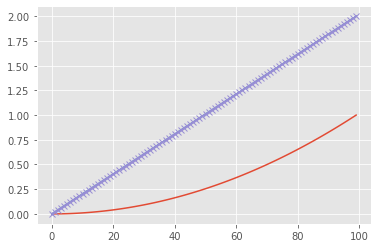

In [5]:
t1 = tf.linspace(0., 1., 100)

"""Tf derivative with GradeintTape"""
def derivative(x):
    
    with tf.GradientTape() as tape:
        tape.watch(x)
        
        y = x**2
    return tape.gradient(y, x)

"""Tf derivative with graph"""    

@tf.function
def derivative_graph(x):
    y = x**2
    dy_dx = tf.gradients(y, x)[0]
    
    return dy_dx
    
    

plt.plot((t1**2).numpy())
plt.plot(derivative(t1).numpy())
plt.plot(derivative_graph(t1).numpy(), '-x')

In [6]:
""" These two are user provided"""

toy_dist = tfd.Mixture(
    cat=tfd.Categorical(probs=[1/3, 2/3]),
    components=[
        tfd.Normal(loc=tf.constant(-2.), scale=tf.constant(1.)),
        tfd.Normal(loc=tf.constant(2.), scale=tf.constant(1.))
    ])



def tf_d_log_prob(x, log_prob = toy_dist.log_prob):
    
    y = log_prob(x)
    
    return tf.gradients(y, x)[0]

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
from numpy import infty

tfd = tfp.distributions


""" The SVGD algorithm """

def tf_d_log_prob(x,  likelihood_density):

    with tf.GradientTape() as tape:
        # tape.watch(x)
        y = likelihood_density(x)          
    gradients = tape.gradient(target=y, sources = x)

    return gradients , y   




def pairwise_distance(x):
    # https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    norm = tf.reduce_sum(x * x, 1)
    norm = tf.reshape(norm, [-1, 1])
    return norm - 2. * tf.matmul(x, tf.transpose(x)) + tf.transpose(norm)


def kernel_fn(Nparticles, x, h=-1):
    
    pdist = pairwise_distance(x)
    # xshape0 =tf.constant(x.shape[0])

    if h == -1:
        # https://stackoverflow.com/questions/43824665/tensorflow-median-value
        lower  = tfp.stats.percentile(pdist, tf.constant(50.0), interpolation='lower')
        higher = tfp.stats.percentile(pdist, tf.constant(50.0), interpolation='higher')

        median = (lower + higher) /tf.constant(2.)
        median = tf.cast(median, tf.float32)

        h = tf.sqrt(tf.constant(1/2) * median / tf.math.log(Nparticles +tf.constant(1.)))
        h = tf.stop_gradient(h)
    Kxy = tf.exp(-1*pdist / h ** 2 /2)

    dxkxy = -1*Kxy@x
    sumkxy = tf.expand_dims(tf.reduce_sum(Kxy, axis=1), axis=1)
    
    dxkxy = dxkxy+x*sumkxy
    dxkxy = dxkxy / (h**2)


    return (Kxy, dxkxy)

def svgd_update(particles, lld):
 
    N = particles.shape[0]  
    # tf.print(N)
    K, dK = kernel_fn(N, particles)   

    # tf.print(K.shape, dK.shape, N)
    dLog, LogP =  tf_d_log_prob(particles, lld)   

    # tf.print("DIS", dLog)

    upd = K@dLog + dK
    
    return upd/N , dLog, LogP

# constraint=lambda x: tf.clip_by_value(x, 0.00001, infty)  

@tf.function(experimental_relax_shapes=True)
def apply_update(particles, lld, historical_grad=None,   lr = 0.05, fudge_factor = 1e-6, alpha = 0.9):
    print('Built Graph')
    grad_particles, _, LogP = svgd_update(particles, lld) 
    
       # adagrad 
    
    
    if historical_grad is None:
        historical_grad =  grad_particles ** 2
    else:
        
        historical_grad = alpha * historical_grad + (1. - alpha) * (grad_particles ** 2)

    adj_grad = tf.math.divide(grad_particles, fudge_factor+tf.math.sqrt(historical_grad))
    particles.assign_add(lr * adj_grad )
        
    return historical_grad , tf.reduce_sum(LogP)


In [11]:
%%time
x0 = np.random.normal(-12,10., [100,1])
tf_prior_space = tf.Variable(x0, dtype=tf.float32)
lld = lambda var: toy_dist.log_prob(var)

CPU times: user 1.15 ms, sys: 75 µs, total: 1.23 ms
Wall time: 1.03 ms


In [12]:
losses = []

historical_grad = None
for i in range(1000):
    historical_grad, log_probablities  = apply_update(tf_prior_space, lld, historical_grad=historical_grad, lr = tf.constant(0.05) )
    losses.append(-log_probablities.numpy())

                



Built Graph
Cause: Unable to locate the source code of <function <lambda> at 0x7f6fec061200>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
Cause: Unable to locate the source code of <function <lambda> at 0x7f6fec061200>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
Built Graph


In [13]:
plt.title('Comparison of theoretical and true pdf')
plt.hist(tf_prior_space.numpy().flatten(), density = True, label = 'SVGD')
plt.plot(x, Model.pdf(x), '-o', label = 'True')
plt.legend()
mpld3.display()